<a href="https://colab.research.google.com/github/odunola25/MSC-project/blob/work/MobileNet_Final_Batch_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

train_dir = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/Brain Tumor MRI Dataset/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/Brain Tumor MRI Dataset/Testing'

image_size = (224, 224)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle = False,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Load the pre-trained MobileNet model
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

from tensorflow.keras import Model, Input

# Define the model using the Functional API
inputs = Input(shape=(224, 224, 3))
x = mobilenet_base(inputs, training=False)  # Use 'training=False' to keep batch norm and dropout layers in inference mode
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

mobilenet_model = Model(inputs, outputs)

# Print model summary
mobilenet_model.summary()

# Fine-tune the MobileNet model
fine_tune_at_mobilenet = 100
mobilenet_base.trainable = True  # Make all layers trainable
for layer in mobilenet_base.layers[:fine_tune_at_mobilenet]:
    layer.trainable = False  # Freeze the layers up to fine_tune_at_mobilenet

# Compile the model
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,286,660 (16.35 MB)

 Trainable params: 4,262,724 (16.26 MB)

 Non-trainable params: 23,936 (93.50 KB)

In [ ]:
# Set up callbacks for MobileNet
early_stopping_mobilenet = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
model_checkpoint_mobilenet = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/32_MobileNet_fine_tuned_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr_mobilenet = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the MobileNet model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[early_stopping_mobilenet, model_checkpoint_mobilenet, reduce_lr_mobilenet],
    verbose=1
)

# Save the final MobileNet model
#mobilenet_model.save('/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/MobileNet_final_model.keras')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3513 - loss: 2.6301 
Epoch 1: val_loss improved from inf to 1.99430, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/32_MobileNet_fine_tuned_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 2179s 23s/step - accuracy: 0.3520 - loss: 2.6283 - val_accuracy: 0.6217 - val_loss: 1.9943 - learning_rate: 1.0000e-05
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.5701 - loss: 2.0700
Epoch 2: val_loss improved from 1.99430 to 1.76539, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/32_MobileNet_fine_tuned_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5704 - loss: 2.0694 - val_accuracy: 0.7086 - val_loss: 1.7654 - learning_rate: 1.0000e-05
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.6701 - loss: 1.8720
Epoch 3: val_loss improved from 1.76539 to 1.64789, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/32_MobileNet_fine_tuned_mode

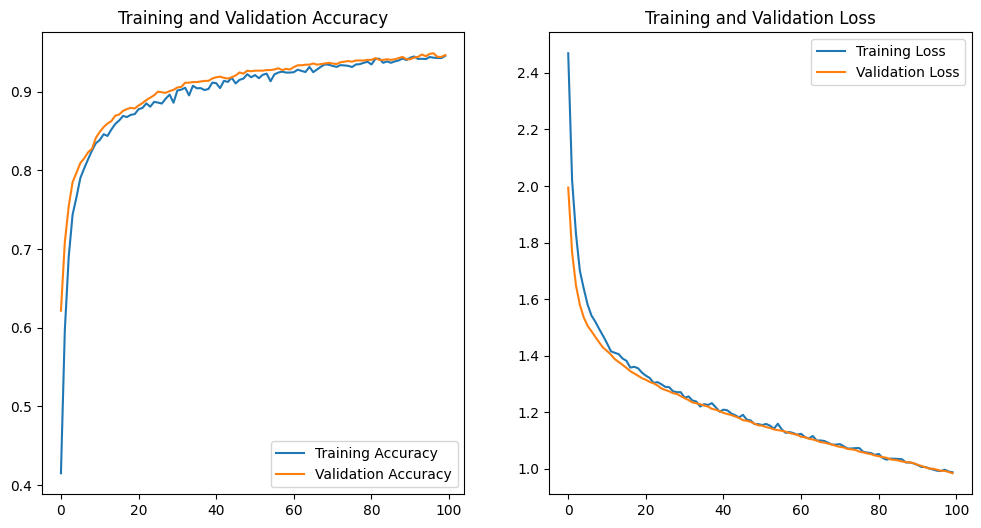

In [ ]:
# Plot the training and validation accuracy and loss curves
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# Load the best model
best_model_path = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/32_MobileNet_fine_tuned_model.keras'

mobilenet_model_32 = tf.keras.models.load_model(best_model_path)

In [ ]:
# Evaluate the best model
test_loss, test_accuracy = mobilenet_model_32.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.9295 - loss: 1.0272
Test Accuracy: 0.9466056227684021


In [ ]:
import os
import glob

def get_number(path):
  if not os.path.exists(path):
    return 0
  count = 0

  for current_path, dirs, files in os.walk(path):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr + "/*")))
  return count

In [ ]:
testing_images = get_number(test_dir)

print("Number of testing samples is", testing_images)

Number of testing samples is 1311


In [ ]:
Classes = ['Glioma', 'Meningioma', 'No Tumour', 'Pituitary']

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_test = test_generator.classes

# predicting our model with test dataset i.e. unseen dataset
pred = mobilenet_model_32.predict(test_generator, testing_images//batch_size+1,verbose=1,).argmax(axis=1)
#print(y_test)
print(pred)
#Classification report of every label
print(classification_report(y_test, pred, target_names = Classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step
[0 0 0 ... 3 3 3]
              precision    recall  f1-score   support

      Glioma       0.96      0.91      0.94       300
  Meningioma       0.92      0.87      0.89       306
   No Tumour       0.98      1.00      0.99       405
   Pituitary       0.92      1.00      0.96       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [ ]:
correct = 0
incorrect = 0
for i in range(len(y_test)):

    #print("Test Sample is: ", y_test[i], "while predicted sample is: ", pred[i])

    if y_test[i] != pred[i]:
        incorrect += 1
    else:
        correct += 1

print('Total number of test cases', ((len(y_test))))
print('Number of correct predictions', correct)
print('Number of incorrect predictions', incorrect)

Total number of test cases 1311
Number of correct predictions 1241
Number of incorrect predictions 70


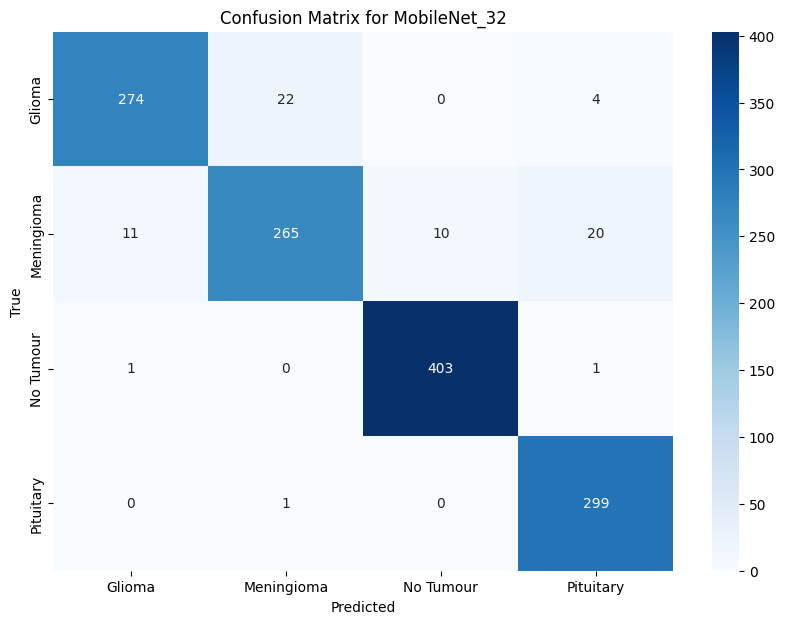

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Classes, yticklabels=Classes)
plt.title('Confusion Matrix for MobileNet_32')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()